# Natural Language Processing on the Cleaned Kaggle Dataset (Part 1)

In this section, I will be using natural language processing to analyse my data set

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook
import textacy
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline


In [3]:
# reading in data 
df = pd.read_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/kaggle-post-eda-190120.csv')

In [4]:
# cleans sentences from stop words and punctuation and filters by pos tags if given
# returns cleaned sentence and tokenized sentence

def process_text(documents, pos=False):

    nlp = textacy.load_spacy_lang('en_core_web_sm')
    
    texts = []
    tokenised_texts = []

    if pos: # pos can either be False or a list of parts of speech
        for document in tqdm_notebook(nlp.pipe(documents, batch_size=200)):
            assert document.is_parsed
            tokens = [token
                      for token in document 
                      if token.is_stop == False
                      and token.pos_ in pos
                      and token.pos_ != 'PUNCT']
            doc_ = ''
            for token in tokens:
                doc_ += str(token) + ' '
            
            doc_ = doc_.strip()
            texts.append(doc_)
            tokenised_texts.append(tokens)
    
    
    else:    
        for document in tqdm_notebook(nlp.pipe(documents, batch_size=200)):
            assert document.is_parsed
            tokens = [token
                      for token in document 
                      if token.is_stop == False
                      and token.pos_ != 'PUNCT']
            doc_ = ''
            for token in tokens:
                doc_ += str(token) + ' '
            
            doc_ = doc_.strip()
            texts.append(doc_)
            tokenised_texts.append(tokens)
            
    return texts, tokenised_texts

In [5]:
# Parts of Speech tagging
pos = ['NOUN', 'ADJ', 'VERB', 'ADV']
processed_quotes, tokenised_quotes = process_text(df['lyrics'], pos=pos)
df['processed_quote'] = processed_quotes
df['tokenised_quotes'] = tokenised_quotes

In [7]:
# sentiment analysis
# measures objectivity (if lyrics are opinionated or objective facts)
# measures polarity (identifies how positive/neutral/negative songs are)

sen = pd.read_csv('../../../../../resource-datasets/sentiment_words/sentiment_words.csv')
sen.pos = sen.pos.map(lambda x: x.upper())
sen['objectivity'] = 1. - (sen.pos_score + sen.neg_score)
sen['pos_vs_neg'] = sen.pos_score - sen.neg_score

In [10]:
sen_dict = defaultdict(dict) # set up a default dictionary with an empty dictionary as default value

for row in tqdm_notebook(sen.itertuples()):
    sen_dict[row.pos] [row.word] = {'objectivity': row.objectivity, 'pos_vs_neg': row.pos_vs_neg}

In [11]:
# check number of words per tag
[(key, len(sen_dict[key])) for key in  sen_dict.keys()]

[('ADJ', 21479), ('NOUN', 117797), ('ADV', 4481), ('VERB', 11529)]

In [12]:
# Determines the average objectivity and positive-versus-negative scores for a given sentence

def scorer(parsed):
   
    obj_scores, pvn_scores = [], []
    for token in parsed:
        try:
            print()
            obj_scores.append(sen_dict[token.pos_][token.lemma_]['objectivity'])
            pvn_scores.append(sen_dict[token.pos_][token.lemma_]['pos_vs_neg'])
        except:
            pass
        
    # set default values if no token found
    if not obj_scores:
        obj_scores = [1.]
    if not pvn_scores:
        pvn_scores = [0.]
        
    return [np.mean(obj_scores), np.mean(pvn_scores)]

In [1]:
scores = df['tokenised_quotes'].map(scorer)
df['objectivity_avg'] = scores.map(lambda x: x[0])
df['polarity_avg'] = scores.map(lambda x: x[1])

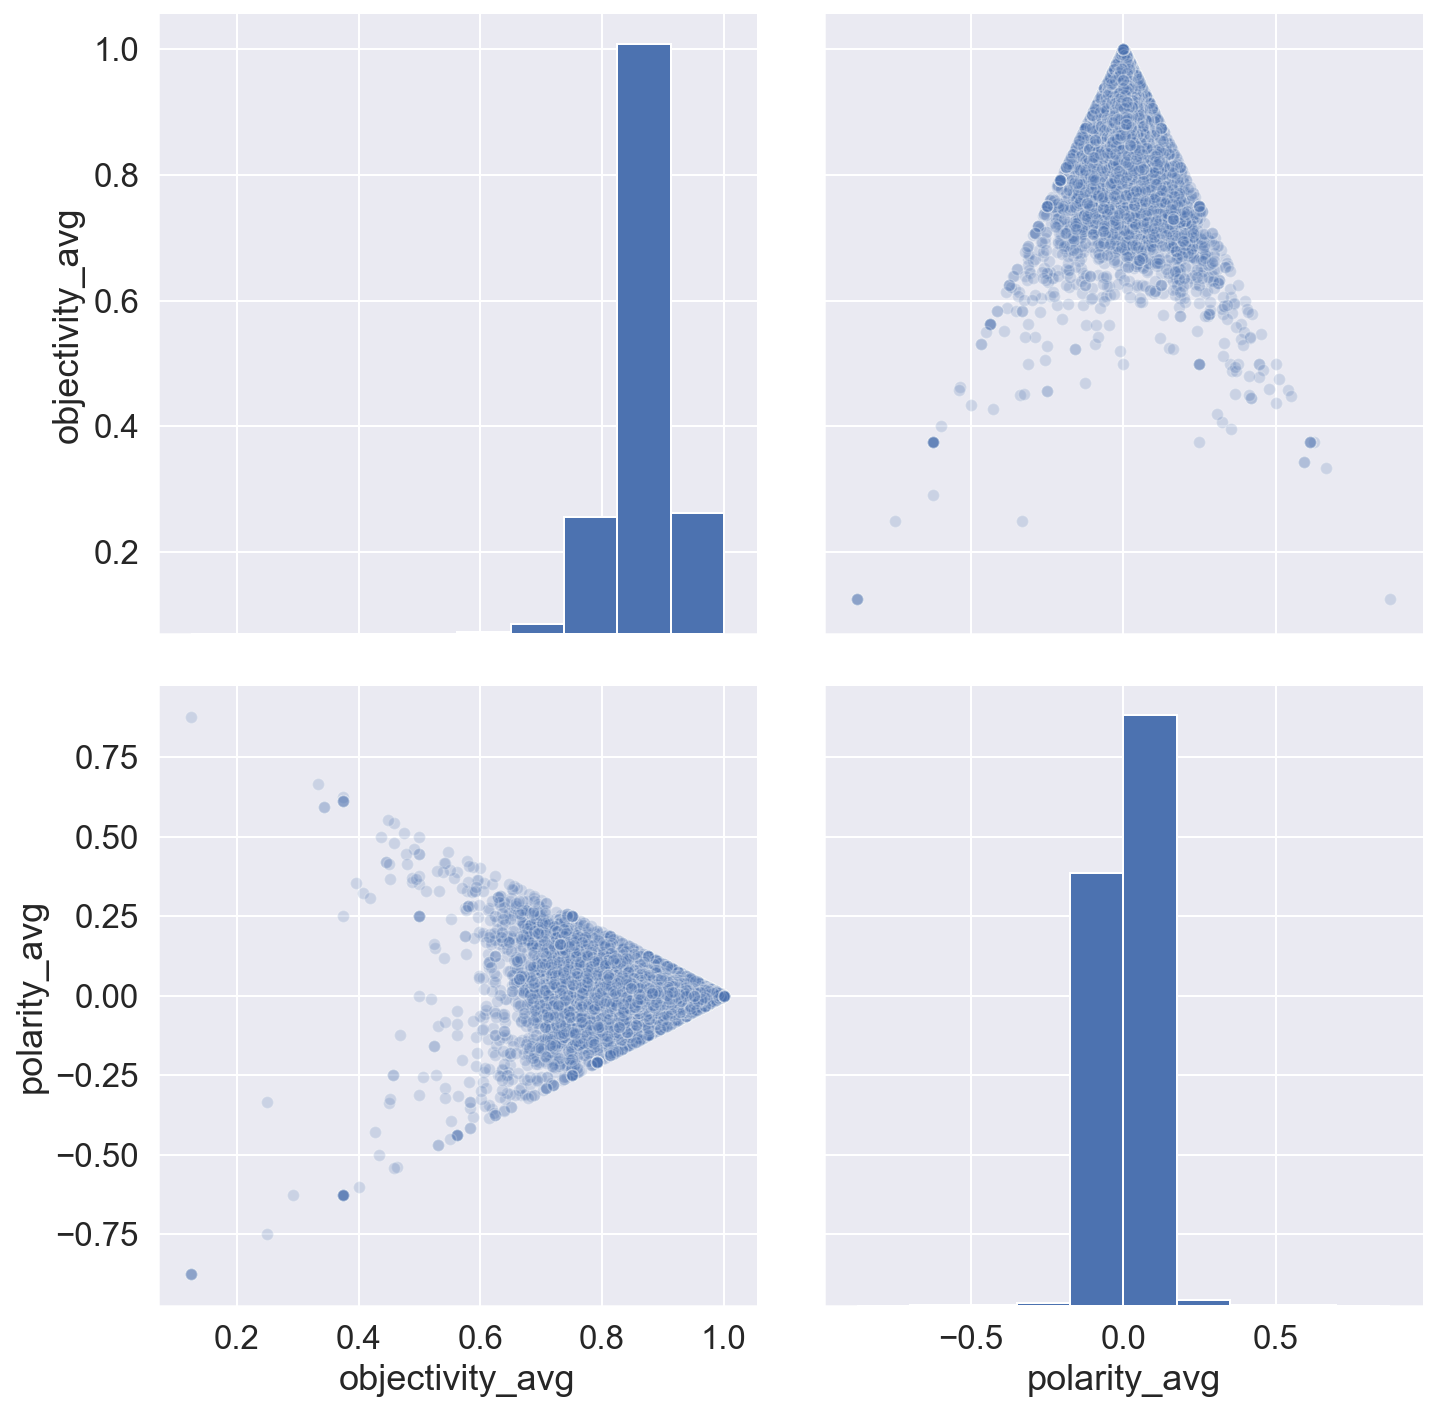

In [14]:
sns.pairplot(df, vars=['objectivity_avg', 'polarity_avg'], 
             plot_kws={'alpha': 0.2}, height=5, palette='purple')
plt.show()

In [31]:
# some of the most positive songs, very repitive and to do with love

for quote in df.sort_values('polarity_avg', ascending=False)['lyrics'][7:10]:
    print(quote)
    print('============================================================\n')

Ariez Onasis Ft. Kevin Cossom - Loving Me Now Ariez Onasis Ft. Kevin Cossom - Loving Me Now

Do you love me Do you love me I love you Do you love me Do you love me Do you love me I love you Do you love me Do you love me I love you Do you love me Do you love me Do you love me I love you Do you love me at all I love you I love you I love you Do you love me I love you Do you love me Do you love me Do you love me at all I love you Do you love me I love you Do you love me Do you love me at all I love you Do you love me I love you Do you love me Do you love me at all I love you Do you love me I love you Do you love me I love you I love you

I like your Mom and its no fad. I wanna marry her and be your Dad. I like your Mom. I like your Mom. I like your Mom. I like... Your Mom. I like your Mom and its no fad. I wanna marry her and be your Dad. I like your Mom. I like your Mom. I like your Mom. I like... Your Mom.



In [32]:
# the most negative songs are foreign languages because the sentiment dictionary used was only for english

for quote in df.sort_values('polarity_avg', ascending=True)['lyrics'][0:3]:
    print(quote)
    print('============================================================\n')

Cuando ya no me quieras No me fingas cariÃ±o No me tengas piedad CompasiÃ³n ni temor Si me diste tu olvido Hoy no te culpo ni riÃ±o Ni te doy el disgusto de mirar Mi dolor PartirÃ© canturreando Mi poema mas triste Contare a todo el mundo Lo que tu me quisiste Y cuando nadie escuche Mis canciones ya viejas DetendrÃ© mi camino en un pueblo Lejano y ahÃ­ morirÃ©

Que difÃ­cil es refugiarse del dolor Cuando se muere cada noche de desamor Que difÃ­cil es dibujar ausencias de ti SoÃ±ando con las sombras de ese tiempo feliz Que difÃ­cil es escapar a mi soledad Y a tantas ilusiones que no volverÃ¡n SÃ³lo huellas del ayer sÃ³lo trazos de un querer Al verte tan lejana y frÃ­a se muere el alma mÃ­a Para olvidar me falta tiempo Para llorar me sobra vida Y no habrÃ¡ dolor mÃ¡s grande Que no volverte a ver Para esperar me falta fuerza Para intentar me sobra fe Y se escapa de mis manos La mujer que tanto ame Para volver me sobran ganas Para aceptar me falta el alma Y se escapa entre las sombras Quien

In [17]:
df.to_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/kaggle-post-nlp-190120.csv', index=False)

In [18]:
df = pd.read_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/kaggle-post-nlp-190120.csv')

In [19]:
df.head()

,Unnamed: 0,song,year,artist,genre,lyrics,acousticness,danceability,duration_ms,energy,...,tempo,time_signature,valence,total_words,unique_words,unique_word_ratio,processed_quote,tokenised_quotes,objectivity_avg,polarity_avg
0,0,ego remix,2009,beyoncé,Pop,Oh baby how you doing You know Im gonna cut ri...,0.114,0.711,283520.0,0.439,...,78.074,4.0,0.3260,433,144,0.332564,baby know m gon cut right chase women like thi...,"[baby, know, m, gon, cut, right, chase, women,...",0.805230,0.043886
1,1,honesty,2009,beyoncé,Pop,If you search For tenderness It isnt hard to f...,0.428,0.565,224387.0,0.442,...,135.990,4.0,0.0717,169,110,0.650888,search tenderness hard find love need live loo...,"[search, tenderness, hard, find, love, need, l...",0.783309,-0.016317
2,2,all i could do was cry,2009,beyoncé,Pop,I heard Church bells ringing I heard A choir s...,0.358,0.372,190400.0,0.488,...,185.262,3.0,0.5000,144,73,0.506944,heard Church bells ringing heard choir singing...,"[heard, Church, bells, ringing, heard, choir, ...",0.891815,-0.010986
3,3,once in a lifetime,2009,beyoncé,Pop,This is just another day that I would spend Wa...,0.171,0.313,239533.0,0.556,...,79.209,3.0,0.4210,295,113,0.383051,day spend right Staring night wishin feel warm...,"[day, spend, right, Staring, night, wishin, fe...",0.841920,0.068590
4,4,save the hero,2009,beyoncé,Pop,I lay alone awake at night Sorrow fills my eye...,0.632,0.550,274573.0,0.472,...,116.966,4.0,0.1610,241,107,0.443983,lay awake night fills eyes m strong cry disgui...,"[lay, awake, night, fills, eyes, m, strong, cr...",0.866951,0.004294


In [26]:
df.drop('Unnamed: 0', axis=1, inplace=True)

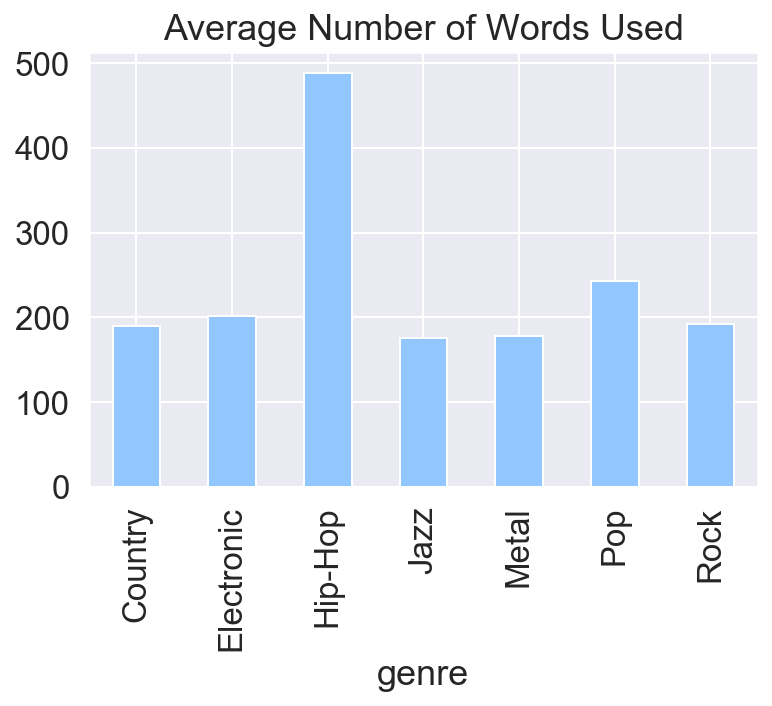

In [20]:
# hip-hop has the highest word average by far - everything else is pretty similar
plt.style.use('seaborn-pastel')
df.groupby('genre')['total_words'].mean().plot(kind='bar', title='Average Number of Words Used');

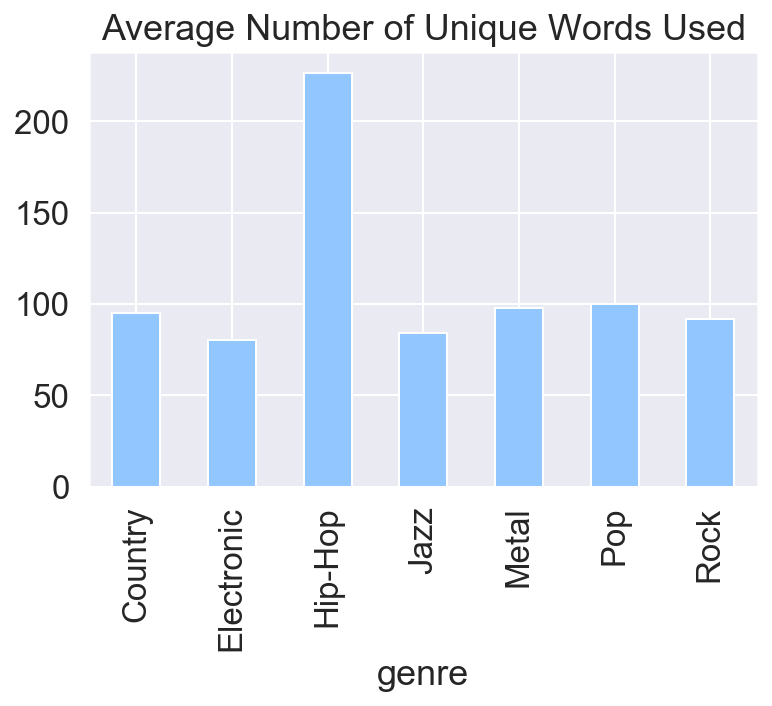

In [21]:
# total number of words + unique words are correlated, hip hop has the highest number of unique words
df.groupby('genre')['unique_words'].mean().plot(kind='bar', title='Average Number of Unique Words Used');

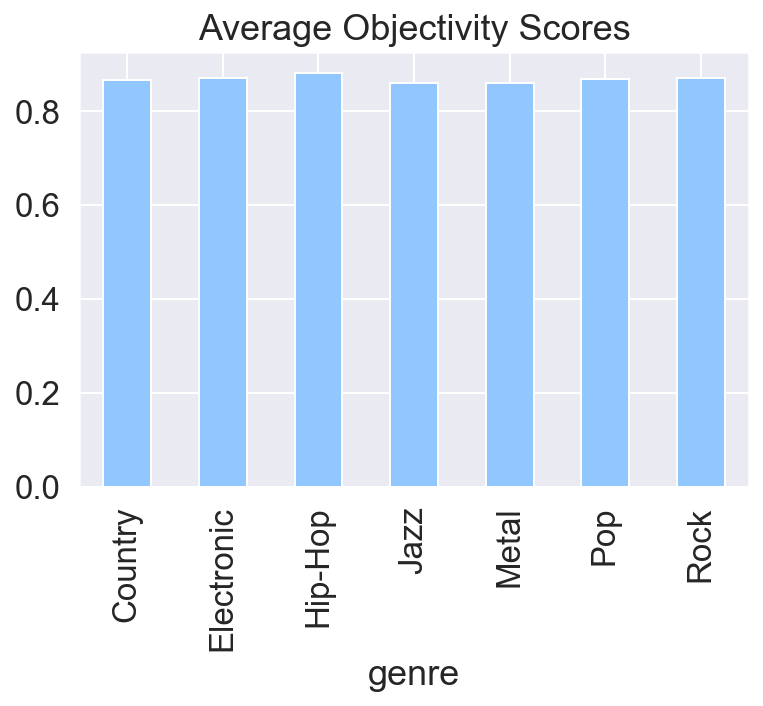

In [22]:
# surprisingly their objectivity scores were all very high
df.groupby('genre')['objectivity_avg'].mean().plot(kind='bar', title='Average Objectivity Scores');

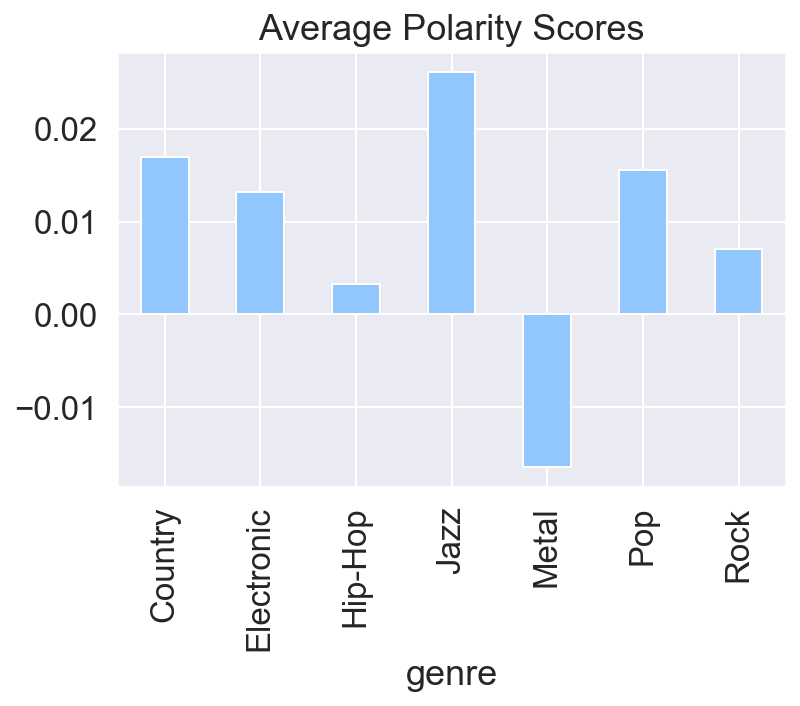

In [23]:
# metal was the only genre with a highly negative sentiment, hip hop remained on the border for its average
df.groupby('genre')['polarity_avg'].mean().plot(kind='bar', title='Average Polarity Scores');